=== Aggregate Statistics ===

Signal Level (dBFS):
  Min     : -38.00
  Median  : -26.50
  Mean    : -26.53
  Std     : 5.03
  Max     : -13.00

Communication Duration (s):
  Min     : 0.00
  Median  : 2.00
  Mean    : 8.59
  Std     : 234.37
  Max     : 52528.00


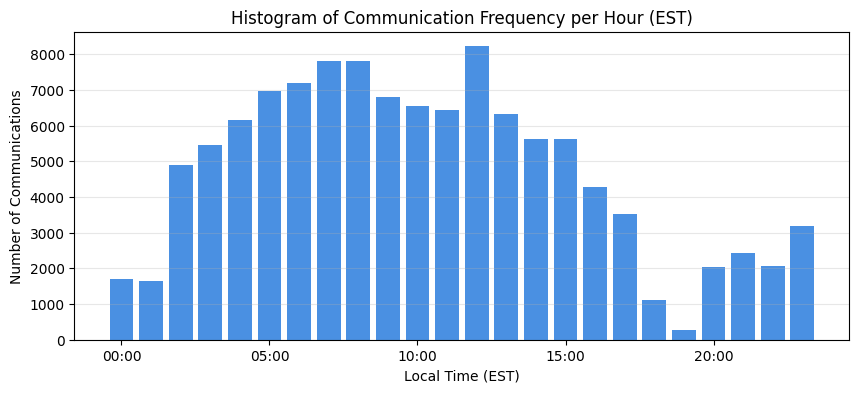

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz  # timezone conversion

# --- 1) Load and parse the log ---
FILE_PATH = "/content/atc_communications (2).txt"  # <-- adjust if needed
pattern = re.compile(r"\[(?P<ts>\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2})\].*?\(dBFS:\s*(?P<dbfs>-?\d+(?:\.\d+)?)\)")

records = []
with open(FILE_PATH, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        m = pattern.search(line.strip())
        if m:
            ts = datetime.strptime(m.group("ts"), "%Y-%m-%d %H:%M:%S")
            dbfs = float(m.group("dbfs"))
            records.append((ts, dbfs))

df = pd.DataFrame(records, columns=["timestamp", "dBFS"]).sort_values("timestamp")

# --- 2) Compute inter-arrival (communication duration proxy) ---
df["delta_s"] = df["timestamp"].diff().dt.total_seconds()
df.loc[df.index[0], "delta_s"] = np.nan

# --- 3) Aggregate statistics ---
def stats(series):
    return {
        "min": np.nanmin(series),
        "median": np.nanmedian(series),
        "mean": np.nanmean(series),
        "std": np.nanstd(series, ddof=1),
        "max": np.nanmax(series)
    }

dbfs_stats = stats(df["dBFS"])
duration_stats = stats(df["delta_s"].dropna())

print("=== Aggregate Statistics ===")
print("\nSignal Level (dBFS):")
for k, v in dbfs_stats.items():
    print(f"  {k.capitalize():<8}: {v:.2f}")

print("\nCommunication Duration (s):")
for k, v in duration_stats.items():
    print(f"  {k.capitalize():<8}: {v:.2f}")

# --- 4) Frequency histogram (hourly communications, in EST) ---
utc = pytz.utc
est = pytz.timezone("US/Eastern")

# Convert UTC to EST
df["timestamp_utc"] = df["timestamp"].dt.tz_localize(utc)
df["timestamp_est"] = df["timestamp_utc"].dt.tz_convert(est)
df["hour_est"] = df["timestamp_est"].dt.hour

# Count events per hour
hourly_counts = df.groupby("hour_est").size()

# Plot histogram
plt.figure(figsize=(10,4))
plt.bar(hourly_counts.index, hourly_counts.values, color="#4a90e2")
plt.title("Histogram of Communication Frequency per Hour (EST)")
plt.xlabel("Local Time (EST)")
plt.ylabel("Number of Communications")

# Show only selected tick labels
tick_hours = [0, 5, 10, 15, 20]
plt.xticks(tick_hours, [f"{h:02d}:00" for h in tick_hours])

plt.grid(True, axis="y", alpha=0.3)
plt.show()

In [4]:
timestamps = []
with open(FILE_PATH, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        m = pattern.search(line.strip())
        if m:
            ts = datetime.strptime(m.group("ts"), "%Y-%m-%d %H:%M:%S")
            timestamps.append(ts)

if timestamps:
    print("=== Communication Time Range ===")
    print(f"First Communication: {min(timestamps)}")
    print(f"Last Communication : {max(timestamps)}")
    print(f"Total Duration     : {max(timestamps) - min(timestamps)}")
else:
    print("No timestamps found in file.")

=== Communication Time Range ===
First Communication: 2025-10-12 12:08:24
Last Communication : 2025-10-23 20:21:15
Total Duration     : 11 days, 8:12:51
